In [2]:
import sys, platform, numpy as np




Python: 3.10.15 | packaged by conda-forge | (main, Oct 16 2024, 01:21:29) [Clang 17.0.6 ]
Executable: /Users/dorukakay/opt/anaconda3/envs/cartpole/bin/python
Platform: macOS-13.5.1-x86_64-i386-64bit
NumPy: 1.26.4


In [3]:
import os, math, random, time
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import gymnasium as gym
from collections import deque, namedtuple
from tqdm import trange

os.makedirs("weights", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch:", torch.__version__, "| Device:", device)


Torch: 2.2.2 | Device: cpu


In [4]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

Transition = namedtuple('Transition', 's a r s2 d')

class ReplayBuffer:
    def __init__(self, capacity=100_000):
        self.buf = deque(maxlen=capacity)
    def __len__(self): return len(self.buf)
    def push(self, s,a,r,s2,d): self.buf.append(Transition(s,a,r,s2,d))
    def sample(self, batch_size):
        import random
        batch = random.sample(self.buf, batch_size)
        s  = np.stack([t.s for t in batch], axis=0)
        a  = np.array([t.a for t in batch], dtype=np.int64)
        r  = np.array([t.r for t in batch], dtype=np.float32)
        s2 = np.stack([t.s2 for t in batch], axis=0)
        d  = np.array([t.d for t in batch], dtype=np.float32)
        return s, a, r, s2, d


In [5]:
def epsilon_schedule(step, total_steps, start=1.0, end=0.05, mode='linear'):
    frac = min(1.0, step / max(1, total_steps))
    if mode == 'cosine':
        return end + (start - end) * 0.5 * (1 + math.cos(math.pi * frac))
    return start + (end - start) * frac

def dqn_update(batch, online, target, opt, gamma=0.99, double=False):
    s, a, r, s2, d = batch
    s   = torch.tensor(s, dtype=torch.float32, device=device)
    a   = torch.tensor(a, dtype=torch.long, device=device).unsqueeze(1)
    r   = torch.tensor(r, dtype=torch.float32, device=device).unsqueeze(1)
    s2  = torch.tensor(s2, dtype=torch.float32, device=device)
    d   = torch.tensor(d, dtype=torch.float32, device=device).unsqueeze(1)

    q = online(s).gather(1, a)

    with torch.no_grad():
        if double:
            a2 = online(s2).argmax(dim=1, keepdim=True)     # select with online
            q2 = target(s2).gather(1, a2)                   # evaluate with target
        else:
            q2 = target(s2).max(dim=1, keepdim=True).values
        y = r + (1.0 - d) * gamma * q2

    loss = nn.SmoothL1Loss()(q, y)
    opt.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(online.parameters(), 10.0)
    opt.step()
    return float(loss.item())


In [8]:

def train_dqn(strategy='curriculum', episodes=800, max_steps=1000, seed=7,
              lr=1e-3, gamma=0.99, batch_size=128, buffer_size=100_000,
              warmup=2000, update_every=1, grad_steps=1, target_update=1000,
              eps_start=1.0, eps_end=0.05, save_name=None):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

    env = gym.make('CartPole-v1')     
    obs, _ = env.reset(seed=seed)
    state_dim, action_dim = env.observation_space.shape[0], env.action_space.n

    online = QNetwork(state_dim, action_dim).to(device)
    target = QNetwork(state_dim, action_dim).to(device)
    target.load_state_dict(online.state_dict())

    opt = optim.Adam(online.parameters(), lr=lr)
    buf = ReplayBuffer(capacity=buffer_size)

    total_steps = episodes * max_steps
    gstep = 0
    lengths = np.linspace(0.4, 1.8, 8)
    best_eval = -1e9

    for ep in trange(1, episodes+1, desc=f"strategy={strategy}"):

           
        if strategy == 'baseline':
            L = 0.8  
            env.unwrapped.length = L

       
        if strategy == 'curriculum':
            L = float(lengths[(ep-1) % len(lengths)])
        else:
            alpha = max(0.0, 1 - ep / max(1, episodes//2))
            u = np.random.beta(2 + 6*alpha, 2)
            L = 0.4 + u * (1.8 - 0.4)
        env.unwrapped.length = L

        s, _ = env.reset()
        done, t = False, 0

        while not done and t < max_steps:
            eps_mode = 'cosine' if strategy == 'double' else 'linear'
            eps = epsilon_schedule(gstep, total_steps, eps_start, eps_end, eps_mode)
            if random.random() < eps:
                a = env.action_space.sample()
            else:
                with torch.no_grad():
                    a = int(online(torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)).argmax().item())

            s2, r, term, trunc, _ = env.step(a)

            if strategy == 'reward_shape':
                x, xdot, th, thdot = s2
                r = float(r - 0.01*abs(x) - 0.05*abs(th))  # tiny shaping, dynamics unchanged

            d = term or trunc
            buf.push(s, a, r, s2, d)
            s = s2
            t += 1
            gstep += 1

            if len(buf) >= warmup and gstep % update_every == 0:
                for _ in range(grad_steps):
                    batch = buf.sample(batch_size)
                    # ✅ FIX: pass 'opt'
                    dqn_update(batch, online, target, opt, gamma=gamma, double=(strategy=='double'))

            if gstep % target_update == 0:
                target.load_state_dict(online.state_dict())

        
        with torch.no_grad():
            env.unwrapped.length = float(np.random.uniform(0.4, 1.8))
            ob, _ = env.reset()
            gret = 0.0
            for _ in range(max_steps):
                a = int(online(torch.tensor(ob, dtype=torch.float32, device=device).unsqueeze(0)).argmax().item())
                ob, rr, tt, tr, _ = env.step(a)
                gret += rr
                if tt or tr:
                    break

        if gret > best_eval:
            best_eval = gret
            name = save_name or f"dqn_{strategy}.pth"
            torch.save(online.state_dict(), os.path.join("weights", name))

    env.close()
    return os.path.join("weights", save_name or f"dqn_{strategy}.pth")


In [9]:
curriculum_path = train_dqn(strategy='curriculum', episodes=800, save_name='dqn_curriculum.pth')
curriculum_path


strategy=curriculum: 100%|████████████████████| 800/800 [19:45<00:00,  1.48s/it]


'weights/dqn_curriculum.pth'

In [10]:
rshape_path = train_dqn(strategy='reward_shape', episodes=800, save_name='dqn_reward_shape.pth')
rshape_path


strategy=reward_shape: 100%|██████████████████| 800/800 [20:37<00:00,  1.55s/it]


'weights/dqn_reward_shape.pth'

In [11]:
double_path = train_dqn(strategy='double', episodes=800, save_name='dqn_double.pth')
double_path


strategy=double: 100%|████████████████████████| 800/800 [22:59<00:00,  1.72s/it]


'weights/dqn_double.pth'

In [19]:

baseline_path = train_dqn(strategy='baseline', episodes=800, save_name='dqn_baseline.pth')
baseline_path


strategy=baseline:   0%|                                | 0/100 [00:00<?, ?it/s]/Users/dorukakay/opt/anaconda3/envs/cartpole/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/Users/dorukakay/opt/anaconda3/envs/cartpole/lib/python3.10/site-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(
strategy=baseline: 100%|██████████████████████| 100/100 [02:25<00:00,  1.46s/it]


'weights/dqn_baseline.pth'

0.4


/Users/dorukakay/opt/anaconda3/envs/cartpole/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0.4482758620689655
0.496551724137931
0.5448275862068965
0.5931034482758621
0.6413793103448275
0.6896551724137931
0.7379310344827587
0.7862068965517242
0.8344827586206897
0.8827586206896552
0.9310344827586207
0.9793103448275863
1.0275862068965518
1.0758620689655172
1.1241379310344828
1.1724137931034484
1.2206896551724138
1.2689655172413792
1.3172413793103448
1.3655172413793104
1.4137931034482758
1.4620689655172412
1.510344827586207
1.5586206896551724
1.6068965517241378
1.6551724137931036
1.703448275862069
1.7517241379310344
1.8


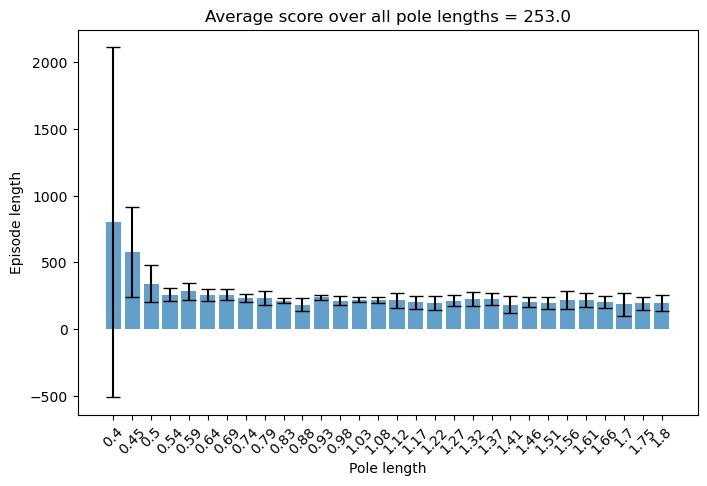

In [16]:
import re, os

assert os.path.exists("test_script.py")

with open("test_script.py", "r", encoding="utf-8") as f:
    src = f.read()

src_mod = re.sub(r"trained_nn\s*=\s*['\"](.+?)['\"]",
                 "trained_nn = 'dqn_curriculum.pth'", src, count=1)

with open("_tmp_test_script_run.py", "w", encoding="utf-8") as f:
    f.write(src_mod)

%run _tmp_test_script_run.py


0.4


/Users/dorukakay/opt/anaconda3/envs/cartpole/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0.4482758620689655
0.496551724137931
0.5448275862068965
0.5931034482758621
0.6413793103448275
0.6896551724137931
0.7379310344827587
0.7862068965517242
0.8344827586206897
0.8827586206896552
0.9310344827586207
0.9793103448275863
1.0275862068965518
1.0758620689655172
1.1241379310344828
1.1724137931034484
1.2206896551724138
1.2689655172413792
1.3172413793103448
1.3655172413793104
1.4137931034482758
1.4620689655172412
1.510344827586207
1.5586206896551724
1.6068965517241378
1.6551724137931036
1.703448275862069
1.7517241379310344
1.8


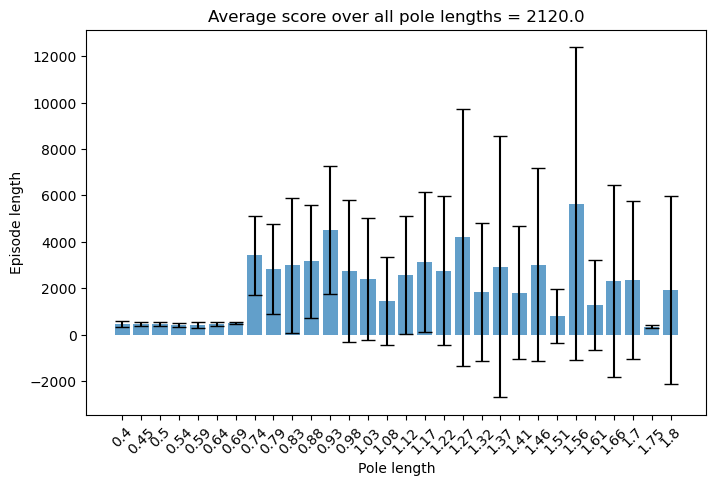

In [17]:
with open("test_script.py", "r", encoding="utf-8") as f:
    src = f.read()
src_mod = re.sub(r"trained_nn\s*=\s*['\"](.+?)['\"]",
                 "trained_nn = 'dqn_reward_shape.pth'", src, count=1)
with open("_tmp_test_script_run.py", "w", encoding="utf-8") as f:
    f.write(src_mod)

%run _tmp_test_script_run.py


0.4


/Users/dorukakay/opt/anaconda3/envs/cartpole/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0.4482758620689655
0.496551724137931
0.5448275862068965
0.5931034482758621
0.6413793103448275
0.6896551724137931
0.7379310344827587
0.7862068965517242
0.8344827586206897
0.8827586206896552
0.9310344827586207
0.9793103448275863
1.0275862068965518
1.0758620689655172
1.1241379310344828
1.1724137931034484
1.2206896551724138
1.2689655172413792
1.3172413793103448
1.3655172413793104
1.4137931034482758
1.4620689655172412
1.510344827586207
1.5586206896551724
1.6068965517241378
1.6551724137931036
1.703448275862069
1.7517241379310344
1.8


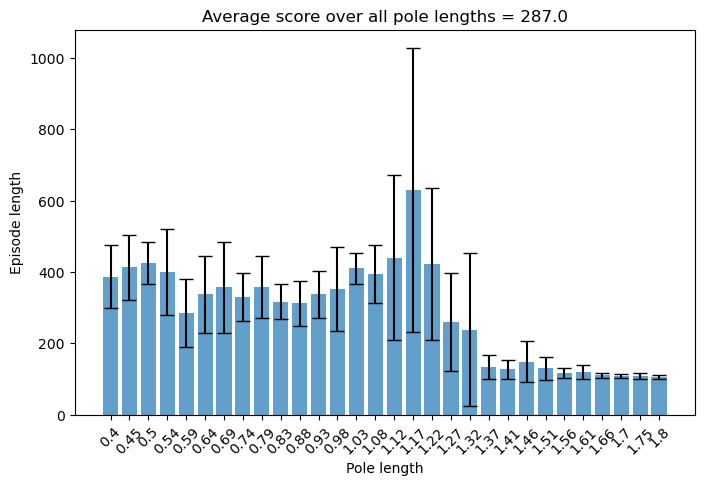

In [18]:
with open("test_script.py", "r", encoding="utf-8") as f:
    src = f.read()
src_mod = re.sub(r"trained_nn\s*=\s*['\"](.+?)['\"]",
                 "trained_nn = 'dqn_double.pth'", src, count=1)
with open("_tmp_test_script_run.py", "w", encoding="utf-8") as f:
    f.write(src_mod)

%run _tmp_test_script_run.py


0.4
0.4482758620689655
0.496551724137931
0.5448275862068965
0.5931034482758621
0.6413793103448275
0.6896551724137931
0.7379310344827587
0.7862068965517242
0.8344827586206897
0.8827586206896552
0.9310344827586207
0.9793103448275863
1.0275862068965518
1.0758620689655172
1.1241379310344828
1.1724137931034484
1.2206896551724138
1.2689655172413792
1.3172413793103448
1.3655172413793104
1.4137931034482758
1.4620689655172412
1.510344827586207
1.5586206896551724
1.6068965517241378
1.6551724137931036
1.703448275862069
1.7517241379310344
1.8


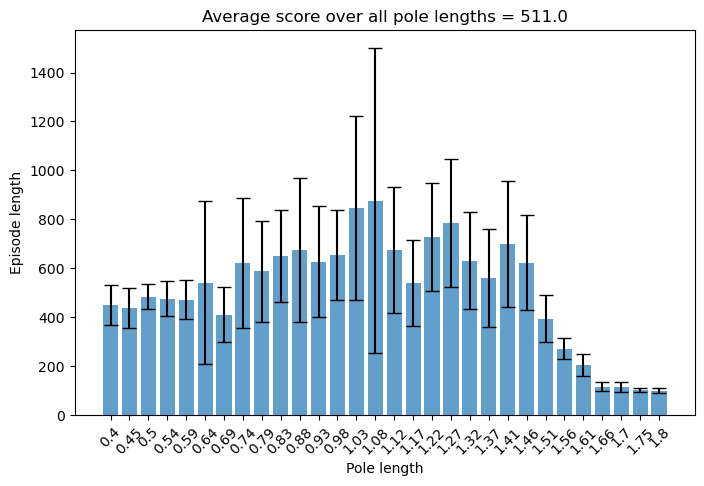

In [20]:
with open("test_script.py", "r", encoding="utf-8") as f:
    src = f.read()

src_mod = re.sub(r"trained_nn\s*=\s*['\"](.+?)['\"]",
                 "trained_nn = 'dqn_baseline.pth'", src, count=1)

with open("_tmp_test_script_run.py", "w", encoding="utf-8") as f:
    f.write(src_mod)

%run _tmp_test_script_run.py
